# StoneGate Integration & Modeling Demo

This notebook demonstrates the modular StoneGate backend and simulator, focusing on:
- Quantum error correction (QEC) modeling and device control
- Device discovery and control via WebSocket RPC
- Physical modeling of cryogenic control (LN2 flow, thermocouples, photonic detectors)

**Theory & Motivation:**
- Quantum computation is highly sensitive to noise; error correction and precise control are essential.
- This demo builds confidence that our backend can control real and simulated devices, model quantum and classical interactions, and provide actionable feedback for experiments.
- The simulator models quantum error rates, device responses to temperature, and feedback control for cryogenic systems.

**Sections:**
1. Quantum error correction: theory, simulation, and API demo
2. Device discovery and control: WebSocket RPC
3. Cryogenic control: modeling, API, and feedback loop
4. Notes on modeling assumptions and confidence-building


In [21]:
# Imports (StoneGate API + QEC)

import os
import sys
from pathlib import Path
import json
import math
import asyncio
from statistics import mean

import numpy as np
import matplotlib.pyplot as plt
import websockets

# Ensure repo-root modules are importable when running from tools/
repo_root = Path.cwd().resolve()
for _ in range(6):
    if (repo_root / 'stonegate_api.py').exists():
        break
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root))

import stonegate_api as sg
import stonegate_qec as qec

# Default to a simulator-friendly endpoint. Override via env var if desired.
# Example: STONEGATE_WS_URL=ws://localhost:8080/status
sg.WS_URL = os.environ.get('STONEGATE_WS_URL', 'ws://localhost:8082/status')
print('StoneGate WS_URL =', sg.WS_URL)

StoneGate WS_URL = ws://localhost:8082/status


## 1. Quantum Error Correction: Theory, Simulation, and API Demo

**Theory:**
- Quantum error correction (QEC) protects quantum information from noise using redundancy and measurement.
- The repetition code is a simple QEC code: logical 0/1 is encoded as multiple physical qubits, and majority vote corrects errors.
- Error rates are modeled as a function of physical noise (e.g., bit-flip probability).

**Modeling:**
- We simulate bit-flip errors and QEC decoding in Python.
- The backend provides a QEC module device and API for submitting measurement data and retrieving correction results.

**Confidence:**
- By comparing simulated error rates and backend QEC results, we validate both the model and the API.
- This demonstrates that the backend can process quantum measurement data and return meaningful results.

In [22]:
# Simple measurement + noise models and decoders (via stonegate_qec)

print('Repetition code error rate example:', qec.logical_error_rate_repetition(trials=1000, p_flip=0.1, rounds=3))

Repetition code error rate example: 0.023


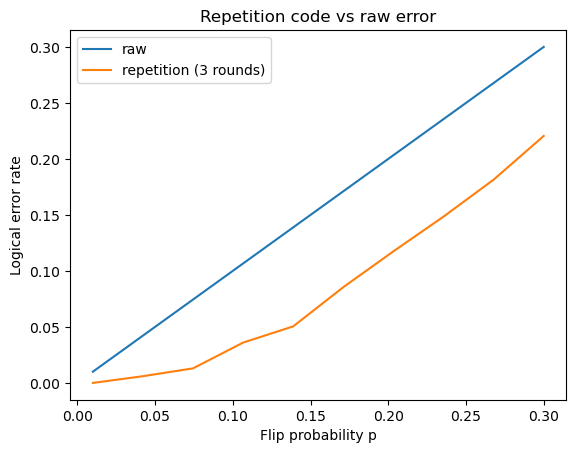

In [23]:
# Parameter sweep: repetition decoding vs raw flip probability

ps = np.linspace(0.01, 0.3, 10)
err_raw = []
err_rep = []
for p in ps:
    err_raw.append(p)
    err_rep.append(qec.logical_error_rate_repetition(trials=2000, p_flip=float(p), rounds=3))

plt.plot(ps, err_raw, label='raw')
plt.plot(ps, err_rep, label='repetition (3 rounds)')
plt.xlabel('Flip probability p')
plt.ylabel('Logical error rate')
plt.legend()
plt.title('Repetition code vs raw error')
plt.show()

## Temperature-Dependent Noise and Refinement

In the simulator/physics model, lower cryogenic target temperature generally reduces noise.

For the demo below, we use a toy mapping from temperature (K) to a bit-flip probability $p$ and show how:
- Logical error increases at warmer targets
- A simple refinement (more syndrome rounds at higher temperature) improves results

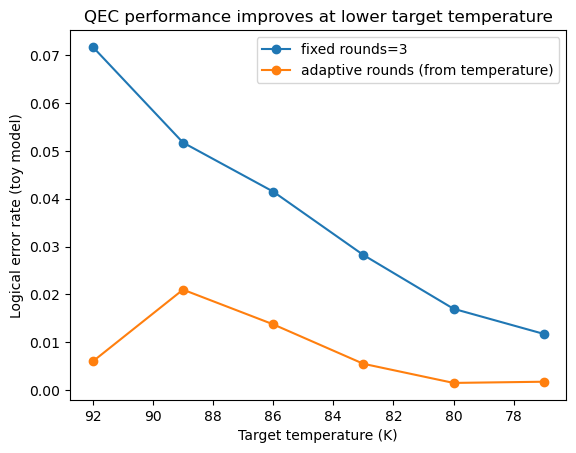

temps_K: [77.0, 80.0, 83.0, 86.0, 89.0, 92.0]
p_flips: [0.0575, 0.0745, 0.0951, 0.1175, 0.1389, 0.1573]
adaptive rounds: [4, 4, 5, 5, 5, 6]


In [24]:
# Temperature sweep: lower target temperature => lower p_flip => lower logical error

temps_K = np.array([77, 80, 83, 86, 89, 92], dtype=float)
p_flips = np.array([qec.p_flip_from_temperature(temperature_K=float(t)) for t in temps_K], dtype=float)

# Baseline: always 3 rounds
err_fixed = np.array([qec.logical_error_rate_repetition(trials=4000, p_flip=float(p), rounds=3) for p in p_flips], dtype=float)

# Refinement: choose more rounds at higher temperature (uses the *measured/recorded* temperature)
rounds_adaptive = np.array([qec.choose_repetition_rounds(temperature_K=float(t)) for t in temps_K], dtype=int)
err_adaptive = np.array([qec.logical_error_rate_repetition(trials=4000, p_flip=float(p), rounds=int(r)) for p, r in zip(p_flips, rounds_adaptive)], dtype=float)

plt.plot(temps_K, err_fixed, marker='o', label='fixed rounds=3')
plt.plot(temps_K, err_adaptive, marker='o', label='adaptive rounds (from temperature)')
plt.gca().invert_xaxis()  # colder on the right is often more intuitive
plt.xlabel('Target temperature (K)')
plt.ylabel('Logical error rate (toy model)')
plt.title('QEC performance improves at lower target temperature')
plt.legend()
plt.show()

print('temps_K:', temps_K.tolist())
print('p_flips:', [round(float(p), 4) for p in p_flips])
print('adaptive rounds:', rounds_adaptive.tolist())

### Using Recorded Hardware/Simulator Values

In practice, you’d parameterize the QEC model using values recorded during the operation (e.g., the cryogenic temperature or ambient pressure at the time of the measurement).
The next cell shows how to pull a temperature reading from `devices.poll` and use it to drive the toy syndrome simulation.

In [25]:
# Use a live reading (if backend/simulator is running) to parameterize syndrome simulation

tK = None
try:
    snap = await sg.poll_all_flat()
    # Prefer a direct LN2 controller temperature if present; else any temperature_K field.
    for device_id, metrics in (snap or {}).items():
        if isinstance(metrics, dict) and 'temperature_K' in metrics:
            tK = float(metrics['temperature_K'])
            print('Using temperature_K from', device_id, ':', tK)
            break
except Exception as e:
    print('devices.poll unavailable; using a synthetic temperature (demo still works):', e)

if tK is None:
    tK = 85.0
p = qec.p_flip_from_temperature(temperature_K=float(tK))
rounds = qec.choose_repetition_rounds(temperature_K=float(tK))
print('Derived p_flip:', round(p, 4), 'chosen rounds:', rounds)

# Simulate a single-qubit syndrome and decode it
true_bit = 0
meas = qec.repetition_measurements(true_bit=true_bit, p_flip=p, rounds=rounds, qubit=0, basis='Z')
decoded = qec.repetition_decode_majority(meas)
print('measurements:', meas)
print('decoded:', decoded, 'true:', true_bit)

Using temperature_K from ln2 : 76.35828739856255
Derived p_flip: 0.0545 chosen rounds: 4
measurements: [{'qubit': 0, 'basis': 'Z', 'round': 0, 'value': 0}, {'qubit': 0, 'basis': 'Z', 'round': 1, 'value': 0}, {'qubit': 0, 'basis': 'Z', 'round': 2, 'value': 0}, {'qubit': 0, 'basis': 'Z', 'round': 3, 'value': 0}]
decoded: 0 true: 0


## Using the backend QEC RPC (over WebSocket)

The next cell builds a small measurement payload and submits it to the backend via `qec.decode` RPC.


## 2. Device Discovery and Control (WebSocket RPC)



This section demonstrates device discovery, polling, and control using the backend WebSocket RPC methods:

- `devices.list`

- `devices.poll`

- `device.action`


In [26]:
# WebSocket RPC: Submit a QEC decode request (via stonegate_qec + stonegate_api)

qec_measurements = [
    qec.make_measurement(qubit=0, basis='Z', round=0, value=1),
    qec.make_measurement(qubit=0, basis='Z', round=1, value=0),
]

try:
    res = await qec.decode_via_rpc(code='repetition', measurements=qec_measurements)
    print(json.dumps(res, indent=2))
except Exception as e:
    print('QEC RPC failed (is the StoneGate backend running?):', e)

{
  "corrections": [
    {
      "correction": 0,
      "qubit": 0,
      "round": 0
    }
  ],
  "job_id": "py_af4a1d9036a04af1bc8cc6841e954f9f",
  "statistics": {
    "measurements": 2,
    "qubits": 1
  },
  "status": "done"
}


In [27]:
# WebSocket RPC: Demo UI-aligned controls ({ set: { metric: value } })

devices = await sg.list_devices()

target_id = None
target_type = None
for dev in devices.get('devices', []):
    if dev.get('type') in ('Laser', 'laser_controller'):
        target_id = dev.get('id')
        target_type = dev.get('type')
        break

if not target_id:
    print('No Laser / laser_controller found (skip)')
else:
    if target_type == 'Laser':
        # Simulator Laser exposes optical_power in its properties.
        await sg.device_set(target_id, optical_power=11.0)
    else:
        # Hardware-style controller mapping (if present).
        await sg.device_set(target_id, intensity=0.25, phase_rad=0.10)

    snap = await sg.poll_all_flat()
    print('Device after set:', target_id, snap.get(target_id, {}))

Device after set: laser0 {'optical_power': 8.429569085038166, 'temperature': 235.74295367119458}


In [28]:
# QEC tooling demo: benchmark + fault injection + simulator tool devices

# Baseline p_flip from the simulator QEC module
snap0 = await sg.poll_all_flat()
p0 = (snap0.get('qec0') or {}).get('p_flip')
t0 = (snap0.get('qec0') or {}).get('temperature_K')
print('Baseline qec0:', {'temperature_K': t0, 'p_flip': p0})

# Benchmark using the new backend-owned micro-benchmark
try:
    b0 = await qec.benchmark_via_rpc(code='repetition', rounds=5, shots=2000, seed=123)
    print('benchmark (baseline):', json.dumps(b0, indent=2))
except Exception as e:
    print('qec.benchmark failed (is backend running?):', e)

# Raise the environment temperature to increase noise, then re-benchmark
await qec.fault_inject_set_env(temperature_K=150)
await asyncio.sleep(0.2)
snap1 = await sg.poll_all_flat()
p1 = (snap1.get('qec0') or {}).get('p_flip')
t1 = (snap1.get('qec0') or {}).get('temperature_K')
print('After fault injection qec0:', {'temperature_K': t1, 'p_flip': p1})

try:
    b1 = await qec.benchmark_via_rpc(code='repetition', p_flip=float(p1), rounds=5, shots=2000, seed=123)
    print('benchmark (after fault injection):', json.dumps(b1, indent=2))
except Exception as e:
    print('qec.benchmark failed:', e)

# Syndrome stream: start, observe, stop
await qec.syndrome_stream_start(device_id='syn0', code_type='repetition', rate_hz=5.0)
await asyncio.sleep(0.6)
snap2 = await sg.poll_all_flat()
print('syn0 snapshot:', snap2.get('syn0'))
await qec.syndrome_stream_stop(device_id='syn0')

# Noise spectrometer: run a scan and parse the payload
await qec.noise_spectrometer_scan(device_id='noise0', band_hz=2000, duration_s=0.5)
snap3 = await sg.poll_all_flat()
noise = snap3.get('noise0') or {}
spec = {}
try:
    spec = json.loads(noise.get('spectrum_json') or '{}')
except Exception:
    spec = {}
print('noise0 summary:', {k: noise.get(k) for k in ['noise_floor','one_over_f_corner_hz','t1_est_s','t2_est_s']})
print('noise0 spectrum_json (parsed):', spec)

Baseline qec0: {'temperature_K': 238.2179557149321, 'p_flip': 0.35}
benchmark (baseline): {
  "job_id": "py_09dcb7986a01449e89fd24afbb7c5512",
  "statistics": {
    "code": "repetition",
    "decoded_error_rate": 0.2395,
    "p_flip": 0.35,
    "raw_error_rate": 0.35,
    "rounds": 5,
    "shots": 2000
  },
  "status": "done"
}
After fault injection qec0: {'temperature_K': 150.13135659610276, 'p_flip': 0.2909597480863597}
benchmark (after fault injection): {
  "job_id": "py_cb744409e7fa46d09893ac232405d407",
  "statistics": {
    "code": "repetition",
    "decoded_error_rate": 0.156,
    "p_flip": 0.2909597480863597,
    "raw_error_rate": 0.2909597480863597,
    "rounds": 5,
    "shots": 2000
  },
  "status": "done"
}
syn0 snapshot: {'code_type': 'repetition', 'p_flip': 0.29520576748038757, 'round': 2, 'running': True, 'syndrome_bit': 1}
noise0 summary: {'noise_floor': 0.049616566469437226, 'one_over_f_corner_hz': 9.329311223902073, 't1_est_s': 0.353588033412971, 't2_est_s': 0.24799090

### Additional simulator QEC tools

These simulator devices are intended as confidence-building instrumentation for QEC workflows:

- `rocal0` (`ReadoutCalibrator`): produces a synthetic readout histogram and threshold
- `leak0` (`LeakageResetController`): models leakage and reset attempts
- `surf0` (`SurfaceCodeController`): estimates a logical error rate vs. distance and environment noise
- `surg0` (`LatticeSurgeryController`): demo operations with success probability tied to noise

In [29]:
# Readout calibration: generate a synthetic histogram/threshold/SNR
await qec.readout_calibrate(device_id='rocal0', target_device='det0', samples=800)
snap = await sg.poll_all_flat()
rocal = snap.get('rocal0') or {}
print('rocal0:', {k: rocal.get(k) for k in ['calibrated','threshold','snr_db','p0_mean','p1_mean']})
try:
    print('rocal0 histogram_json:', json.loads(rocal.get('histogram_json') or '{}'))
except Exception:
    print('rocal0 histogram_json:', rocal.get('histogram_json'))

# Leakage/reset: inject leakage then attempt a reset
await qec.leakage_set_fraction(device_id='leak0', target_device='qec0', leakage_fraction=0.35)
await qec.leakage_attempt_reset(device_id='leak0')
snap = await sg.poll_all_flat()
leak = snap.get('leak0') or {}
print('leak0:', {k: leak.get(k) for k in ['leakage_fraction','reset_success_prob','last_reset_ok','last_reset_ts_ms']})

# Surface code controller: configure distance and run cycles (toy estimate)
await qec.surface_configure_and_run(device_id='surf0', distance=5, cycles=50)
snap = await sg.poll_all_flat()
surf = snap.get('surf0') or {}
print('surf0:', {k: surf.get(k) for k in ['distance','cycle','logical_error_rate_est','active']})

# Lattice surgery demo: run an operation and inspect success probability
await qec.lattice_surgery_run_demo(device_id='surg0', operation='merge')
snap = await sg.poll_all_flat()
surg = snap.get('surg0') or {}
print('surg0:', {k: surg.get(k) for k in ['operation','success_prob','last_run_ts_ms']})

rocal0: {'calibrated': True, 'threshold': 0.5015971453873667, 'snr_db': 6.048030667599534, 'p0_mean': 0.41609020394372964, 'p1_mean': 0.6013193857014395}
rocal0 histogram_json: {'p0_mean': 0.41000000000000003, 'p1_mean': 0.59, 'samples': 800}
leak0: {'leakage_fraction': 0.07011207496625337, 'reset_success_prob': 0.5928875732774391, 'last_reset_ok': True, 'last_reset_ts_ms': 1750195699541.5447}
surf0: {'distance': 5, 'cycle': 100, 'logical_error_rate_est': 0.9844511613494207, 'active': True}
surg0: {'operation': 'merge', 'success_prob': 0.2718479392487628, 'last_run_ts_ms': 1756935884776.1797}


## 3. Cryogenic Control: Modeling, API, and Feedback Loop

**Theory:**
- Many quantum devices require cryogenic temperatures, achieved via LN2 (liquid nitrogen) cooling.
- Device performance (e.g., noise in photonic detectors) depends strongly on temperature.
- Feedback control is used to adjust LN2 flow rate to maintain a target temperature, using thermocouple readings.

**Modeling:**
- The simulator models:
  - LN2CoolingControllerDevice: controls LN2 flow rate
  - ThermocoupleDevice: measures temperature
  - Photonic detectors: noise decreases as temperature drops
- The physics engine provides a function to automatically adjust flow rate to reach a target temperature within tolerance.

**Confidence:**
- By setting flow rates and observing device responses, we validate the physical model and feedback control logic.
- This builds confidence that the backend can control real hardware and simulate realistic quantum-classical interactions.

### Modeling Assumptions
- LN2 flow rate directly affects cooling power; higher flow = faster cooling, but diminishing returns.
- Thermocouple readings are subject to noise, but mean temperature tracks true value.
- Photonic detector noise is modeled as a function of temperature: noise decreases exponentially as temperature drops.
- Feedback control loop uses a simple proportional controller (P-controller) to adjust flow rate.

### API Demonstration Plan
- Set LN2 flow rate via API and observe temperature/photonic detector response.
- Use the feedback control API to automatically reach a target temperature.
- Plot temperature and noise over time to visualize system response.

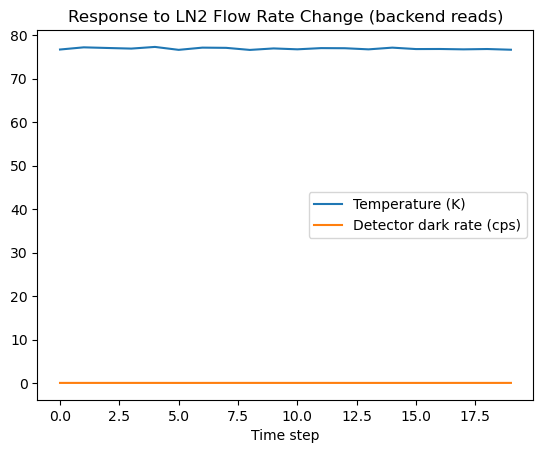

In [30]:
# WebSocket RPC: Set LN2 flow rate and observe temperature / detector response

import time

# IDs match shared/protocol/DeviceGraph.json (simulator default graph).
LN2_ID = 'ln2'
THERMO_ID = 'tc0'
PHOTONIC_ID = 'det0'

async def set_ln2_flow(flow_rate_Lmin: float):
    # Uses the same generic { set: { metric: value } } shape as the UI.
    return await sg.device_set(LN2_ID, flow_rate_Lmin=float(flow_rate_Lmin))

async def poll_temp_and_detector(n=10, delay_s=0.5):
    temps_K, counts, dark_rates = [], [], []
    for _ in range(n):
        snap = await sg.poll_all_flat()
        thermo = snap.get(THERMO_ID, {})
        ln2 = snap.get(LN2_ID, {})
        det = snap.get(PHOTONIC_ID, {})

        # Prefer explicit K metrics when available; fall back to thermocouple C.
        if "temperature_K" in ln2:
            temps_K.append(float(ln2["temperature_K"]))
        elif "temperature_C" in thermo:
            temps_K.append(float(thermo["temperature_C"]) + 273.15)
        else:
            temps_K.append(float('nan'))

        counts.append(float(det.get("counts", float('nan'))))
        dark_rates.append(float(det.get("dark_rate", float('nan'))))
        await asyncio.sleep(delay_s)
    return temps_K, counts, dark_rates

# Example: set flow rate and observe
await set_ln2_flow(2.0)
temps_K, counts, dark_rates = await poll_temp_and_detector(n=20, delay_s=0.3)

plt.plot(temps_K, label='Temperature (K)')
plt.plot(dark_rates, label='Detector dark rate (cps)')
plt.xlabel('Time step')
plt.legend()
plt.title('Response to LN2 Flow Rate Change (backend reads)')
plt.show()

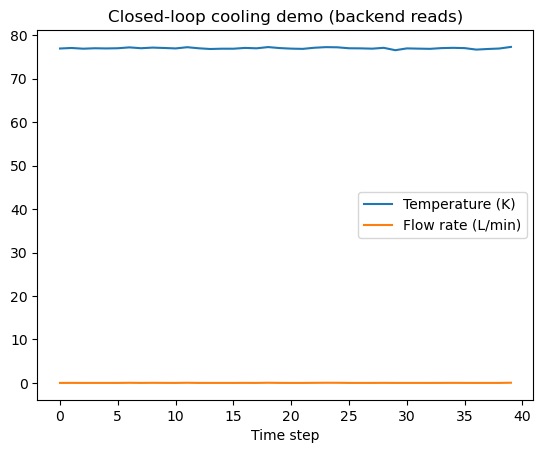

In [31]:
# WebSocket RPC: Simple feedback control loop (implemented in-notebook)

# Demonstrates closed-loop control where all observed values come from backend reads.
TARGET_K = 77.0
K_P = 0.15  # proportional gain for flow rate
MAX_FLOW = 10.0

temps_K = []
flows = []

for _ in range(40):
    snap = await sg.poll_all_flat()
    thermo = snap.get(THERMO_ID, {})
    ln2 = snap.get(LN2_ID, {})

    if "temperature_K" in ln2:
        tK = float(ln2["temperature_K"])
    elif "temperature_C" in thermo:
        tK = float(thermo["temperature_C"]) + 273.15
    else:
        tK = float('nan')

    err = tK - TARGET_K
    flow = max(0.0, min(MAX_FLOW, K_P * err))
    await set_ln2_flow(flow)
    temps_K.append(tK)
    flows.append(flow)
    await asyncio.sleep(0.3)

plt.plot(temps_K, label='Temperature (K)')
plt.plot(flows, label='Flow rate (L/min)')
plt.xlabel('Time step')
plt.legend()
plt.title('Closed-loop cooling demo (backend reads)')
plt.show()

In [32]:
# WebSocket: Observe live measurement_update messages (streaming)

# Note: the backend streams updates automatically; we just print a few.



async def print_live_messages(seconds=2.0):

    async with websockets.connect(sg.WS_URL) as ws:

        t0 = asyncio.get_event_loop().time()

        while asyncio.get_event_loop().time() - t0 < seconds:

            msg = json.loads(await ws.recv())

            if msg.get("type") == "measurement_update":

                print("measurement_update (updates=", len(msg.get("updates", [])), ")")

                # print first update only to keep output small

                if msg.get("updates"):

                    print(json.dumps(msg["updates"][0], indent=2)[:800])



await print_live_messages(2.0)


measurement_update (updates= 18 )
{
  "id": "laser0",
  "measurement": {
    "measurements": {
      "optical_power": {
        "uncertainty": 0.09858043298259642,
        "value": 9.858043298259641
      },
      "temperature": {
        "uncertainty": 1.4751558324223197,
        "value": 147.51558324223197
      }
    },
    "state": "nominal",
    "ts": 1768143870054
  }
}
measurement_update (updates= 18 )
{
  "id": "laser0",
  "measurement": {
    "measurements": {
      "optical_power": {
        "uncertainty": 0.09866280377855928,
        "value": 9.866280377855928
      },
      "temperature": {
        "uncertainty": 1.475662696872884,
        "value": 147.5662696872884
      }
    },
    "state": "nominal",
    "ts": 1768143870554
  }
}
measurement_update (updates= 18 )
{
  "id": "laser0",
  "measurement": {
    "measurements": {
      "optical_power": {
        "uncertainty": 0.09986222842723344,
        "value": 9.986222842723343
      },
      "temperature": {
        "unce

In [33]:
# WebSocket RPC: QEC decode request (same as above, shown here in the WebSocket section)

qec_measurements = [

    {'qubit': 0, 'basis': 'Z', 'round': 0, 'value': 1},

    {'qubit': 0, 'basis': 'Z', 'round': 1, 'value': 0},

]

try:
    res = await qec.decode_via_rpc(code='repetition', measurements=qec_measurements)
    print(json.dumps(res, indent=2))
except Exception as e:
    print('QEC RPC failed (is the StoneGate backend running?):', e)


{
  "corrections": [
    {
      "correction": 0,
      "qubit": 0,
      "round": 0
    }
  ],
  "job_id": "py_8d10eff087ce4ed380029b0857464d50",
  "statistics": {
    "measurements": 2,
    "qubits": 1
  },
  "status": "done"
}


In [34]:
# WebSocket RPC: QEC decode request (repeated here in the WebSocket section)

qec_measurements = [
    qec.make_measurement(qubit=0, basis='Z', round=0, value=1),
    qec.make_measurement(qubit=0, basis='Z', round=1, value=0),
]

try:
    res = await qec.decode_via_rpc(code='repetition', measurements=qec_measurements)
    print(json.dumps(res, indent=2))
except Exception as e:
    print('QEC RPC failed (is the StoneGate backend running?):', e)

{
  "corrections": [
    {
      "correction": 0,
      "qubit": 0,
      "round": 0
    }
  ],
  "job_id": "py_62e89649233149a3bdb3f26fe48b082a",
  "statistics": {
    "measurements": 2,
    "qubits": 1
  },
  "status": "done"
}


## 4. Notes on Modeling Assumptions and Confidence-Building

- The simulator uses simplified but physically motivated models for device behavior and quantum error rates.
- LN2 cooling and temperature feedback are modeled with a proportional controller; real systems may require more advanced control.
- Photonic detector noise is modeled as an exponential function of temperature, capturing the key physical trend.
- Quantum error correction is demonstrated with the repetition code, but the backend is extensible to more advanced codes.

**Confidence:**
- By demonstrating closed-loop control, device response, and quantum error correction, we build trust that the backend can control real experiments and provide meaningful simulation results.
- Users can extend these examples to their own devices, codes, and control strategies.